In [1]:
from classification_utils import *

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet_pretrained = resnet50(pretrained=True)
        self.resnet_pretrained.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3),
                              stride=(2, 2),padding=(3, 3), bias=False)
        
        self.fc1 = nn.Linear(self.resnet_pretrained.fc.out_features, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)  # output size changed to 2
        self.dropout = nn.Dropout(p=0.15)
    def forward(self, image):
        img_features = self.resnet_pretrained(image)
        img_features = torch.flatten(img_features, 1)
        img_features = self.fc1(img_features)
        x = self.relu(img_features)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [14]:
def train(model, loss, opt, dataloader):
    model.train()
    train_loss_total, train_acc_total = 0, 0
    progress = tqdm(enumerate(dataloader), desc="Train Loss: ", total=len(dataloader))
    
    for i, batch in enumerate(dataloader):
        x = batch['img'].float()
        y = batch['lbl'].unsqueeze(1).to(torch.float64)
        output = model(x)
        print(output)
#         predictions = torch.argmax(output, axis=1).unsqueeze(dim=1)        # Calculate loss
        output_binary = np.zeros(output.shape)
        output_binary[output.cpu().detach().numpy() >= 0] = 1
        
        # Derive accuracy score
        label = y.cpu().detach().numpy()
        acc = accuracy_score(label, output_binary)
        print(label)
        print(acc)
        train_acc_total += acc

        # Calculate loss
        loss_epoch = loss(output, y.reshape(-1, 1))
        train_loss_total += loss_epoch.item()
        progress.set_description("Train Loss: {:.4f}".format(train_loss_total / (i + 1)))

        
        # Learning
        opt.zero_grad()
        loss_epoch.backward()
        opt.step()

    return train_loss_total/len(dataloader), train_acc_total/len(dataloader)

In [15]:
def test(model, loss, dataloader):
    model.eval()

    test_loss_total, test_acc_total = 0, 0
    test_label_total, test_pred_total = [], []
    progress = tqdm(enumerate(dataloader), total=len(dataloader))
    with torch.no_grad():
        for k, batch in progress:
            x, y = batch['img'].float(), batch['lbl'].unsqueeze(1).to(torch.float64)
            output = model(x)

            predictions = torch.argmax(output, axis=1).unsqueeze(dim=1)  
            
            # Calculate loss
            loss_epoch = loss(predictions.float(), y).requires_grad_()
            test_loss_total += loss_epoch.item()
            progress.set_description("Test Loss: {:.4f}".format(test_loss_total / (k + 1)))

            # Derive binary output
            output_binary = np.zeros(output.shape)
            output_binary[output.cpu().detach().numpy() >= 0] = 1
            label = y.cpu().detach().numpy()

            test_pred_total += list(output_binary[:, 0])
            test_label_total += list(label)

            # Derive accuracy score
            acc = accuracy_score(y.cpu().detach().numpy(), predictions)
            test_acc_total += acc
    return test_loss_total/len(dataloader), test_acc_total/len(dataloader), test_label_total, test_pred_total, k

In [16]:
def train_model(model, epochs, batch_size):

# if torch.cuda.is_available():
#     model.cuda()
    opt = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9880160542000381)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min',
                                                factor=0.5, threshold=1e-4,
                                                min_lr=1e-6)
    loss_train, loss_test, train_acc,test_acc =[],[],[],[]
    epoch_table = pd.DataFrame()
    # Create datasets
    data_pos = create_dataset(datadir= '/hpc/home/srs108/thilafushi/none_sorted_images/positive')
    data_neg = create_dataset(datadir= '/hpc/home/srs108/thilafushi/none_sorted_images/negative')
    data_all =  torch.utils.data.ConcatDataset([data_pos, data_neg])

    # # Initialize data loaders
    train_data, test_data = train_test_split(data_all, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

    train_dl = DataLoader(train_data, batch_size=batch_size, num_workers=4, pin_memory=True)
    val_dl = DataLoader(val_data, batch_size=batch_size)
    test_dl = DataLoader(test_data, batch_size=batch_size)
    best_acc = 0
    for epoch in range(epochs):
        #Training 
        train_loss, train_acc = train(model, loss, opt, train_dl)
            

        torch.cuda.empty_cache()
        
        # Val
#         val_loss, val_acc, val_label_total, val_pred_total, k = test(model, loss, val_dl)
        
#         print(("Epoch {:d}: train loss={:.3f}, test loss= {:.3f}, "
#                "train acc={:.3f}, test acc={:.3f}").format(
#                    epoch + 1, train_loss, val_loss,
#                    train_acc, val_acc))
        
        scheduler.step(val_loss)
        
#         if val_acc > best_acc:
#             print(f"Improved Accuracy: {val_acc}")
#             best_acc = val_acc
#             best_model_weights = model.state_dict()
#             torch.save(model.state_dict(), 'best_model_weights.pt')

        # Generate confusion matrix
#         if epoch == epochs - 1:
#             array = confusion_matrix(np.array(val_label_total), np.array(val_pred_total))
#             cm = pd.DataFrame(array, range(2), range(2))
#             svm = sns.heatmap(cm, annot=True)
#             figure = svm.get_figure()
# #             image_dir = "../images/test"
#             figure.savefig(f"conf_matrix.png")

#         torch.cuda.empty_cache()

#         epoch_table['epoch'] = epoch
#         epoch_table["training loss"] = train_loss
#         epoch_table["training accuracy"] = train_acc
#         epoch_table["val loss"] = val_loss
#         epoch_table["val accuracy"] = val_acc
    
#     #Testing
#     model.load_state_dict(torch.load('best_model_weights.pt'))
#     test_loss, test_acc, test_label_total, test_pred_total, k = test(model, loss, test_dl)

    print(f"Testing Accuracy: {test_acc}")
    print(f"Testing Loss: {test_loss}")
    return model, epoch_table

In [17]:
# run model training
loss = nn.BCEWithLogitsLoss()
model = CNN()
epochs = 200
batch_size = 16
start = time.time()
trained_model, epoch_table = train_model(model, epochs, batch_size)

print(f"Run time: {( time.time() - start)/3600}h")


tensor([[-0.0085],
        [-0.1586],
        [-0.1427],
        [-0.1097],
        [-0.1721],
        [-0.0020],
        [-0.3345],
        [-0.0565],
        [ 0.0095],
        [ 0.0364],
        [-0.0173],
        [-0.0740],
        [-0.0806],
        [-0.1837],
        [-0.1933],
        [-0.1018]], grad_fn=<AddmmBackward0>)
[[1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]]
0.5625
tensor([[-0.0906],
        [ 0.0683],
        [ 0.0083],
        [-0.0122],
        [-0.1450],
        [-0.0262],
        [-0.2383],
        [-0.3058],
        [-0.0969],
        [-0.1406],
        [-0.2715],
        [-0.0711],
        [-0.0895],
        [-0.2079],
        [-0.0860],
        [-0.1150]], grad_fn=<AddmmBackward0>)
[[0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
0.25
tensor([[-0.0390],
        [-0.1638],
        [-0.0355],
        [ 0.0624],
        [-0.0731],
        [-0.1812],
        [-0.2470],

KeyboardInterrupt: 

In [18]:
# Set 'epoch' column as index
epoch_table = epoch_table.set_index("epoch")

# Convert training and test accuracy values to percentages
epoch_table['training accuracy'] = epoch_table['training accuracy']*100
epoch_table['test accuracy'] = epoch_table['test accuracy']*100

# Round all values in the DataFrame to two decimal places
epoch_table = epoch_table.apply(lambda x: round(x, 2))

# Visualize the table
epoch_table.style.background_gradient(cmap='Blues').set_precision(2)

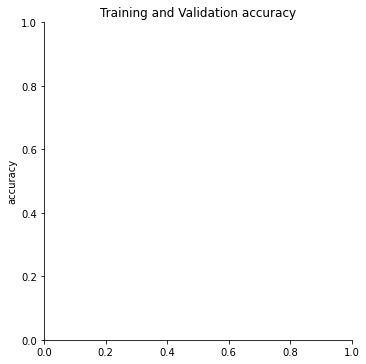

In [139]:
# Plot training and testing accuracy
epoch_table_acc = epoch_table[['training accuracy','val accuracy']]
acc_plot = sns.relplot(data=epoch_table_acc, kind="line")
acc_plot.set(ylabel="accuracy",title = "Training and Validation Accuracy")
plt.savefig("accuracy.png")

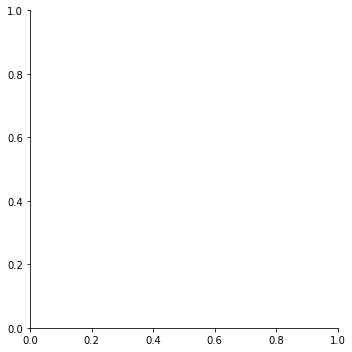

In [141]:
# Plot training and testing loss
epoch_table_loss = epoch_table[['training loss','val loss']]
acc_plot = sns.relplot(data=epoch_table_loss, kind="line")
# acc_plot.set(ylabel="loss",title = "Training and Validation Loss")
# plt.savefig("loss.png")